In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SHIBASISH\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
#Read dataset
df = pd.read_csv('C:/Users/SHIBASISH/Desktop/Jupyter_Notebook/Project/New_1/archive/Reviews.csv')

In [12]:
df = df.head(500)

In [13]:
np.shape(df)

(500, 10)

VADER (Valence Aware Dictionary and sEntiment Reasoner) SENTIMENT SCORING:

Uses a bag of words approach:
1. Stop words are removed.
2. Each word is scored and cobined to a total score.

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [15]:
sia.polarity_scores('9/11 was a very tragic incident')

{'neg': 0.452, 'neu': 0.548, 'pos': 0.0, 'compound': -0.5095}

In [16]:
#Run this on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index':'Id'})
vaders = vaders.merge(df, how = 'left')

In [18]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Text(0.5, 1.0, 'Compound Score by Amazon Review Stars')

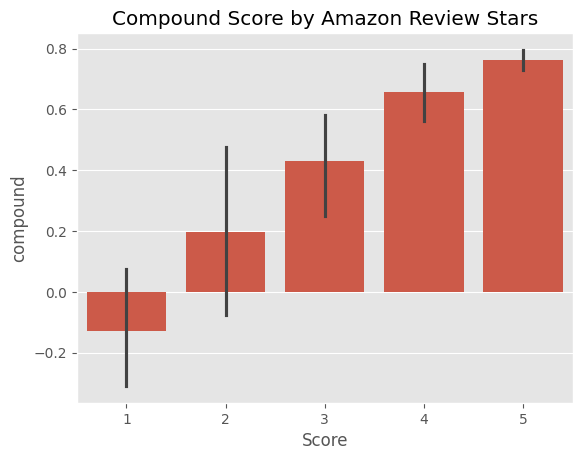

In [19]:
#Plot compound against stars
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound')
ax.set_title('Compound Score by Amazon Review Stars')

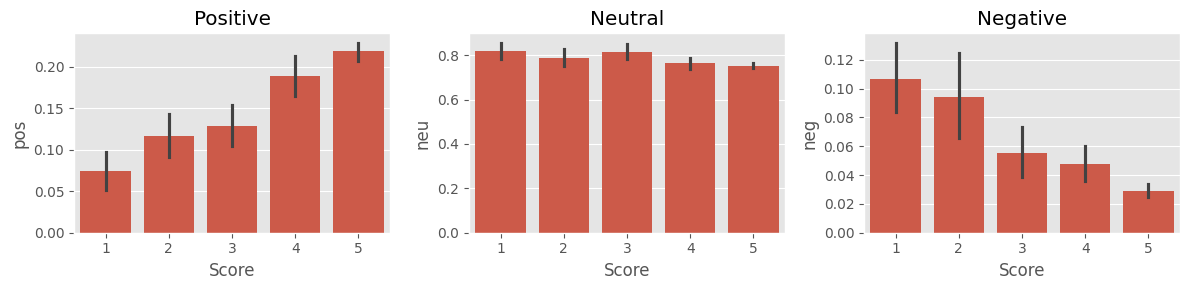

In [20]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3))
sns.barplot(data = vaders, x = 'Score', y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x = 'Score', y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x = 'Score', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()

RoBERTa Pretrained Model

1. Use a model trained of a large corpus of data.
2. Transformer model accounts for words, but also the context of words.

In [21]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [24]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [25]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt') #pt for pytorch
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy() #transform into a numpy array
    scores = softmax(scores)
    scores_dict = { 'roberta_neg' : scores[0], 'roberta_neu' : scores[1], 'roberta_pos' : scores[2]}
    return scores_dict
    

In [27]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_results = polarity_scores_roberta(text)
        res[myid] = roberta_results
    except RuntimeError:
        print(f'Process broke on {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Process broke on 83
Process broke on 187


In [30]:
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns = {'index':'Id'})
roberta = roberta.merge(df, how = 'left')

In [31]:
roberta.head()

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


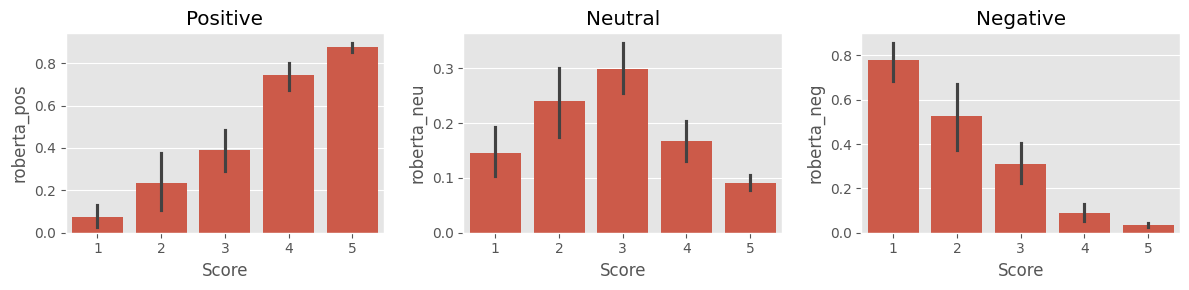

In [32]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3))
sns.barplot(data = roberta, x = 'Score', y = 'roberta_pos', ax = axs[0])
sns.barplot(data = roberta, x = 'Score', y = 'roberta_neu', ax = axs[1])
sns.barplot(data = roberta, x = 'Score', y = 'roberta_neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()